In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
%%capture
!pip install torchvision

#### Prepare for Dataset

In [11]:
transform = transforms.Compose(
    [transforms.Resize((227, 227)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Choose a Device

In [12]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [4]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.features = nn.Sequential(
            DepthwiseSeparableConv(16, 32, stride=1),
            DepthwiseSeparableConv(32, 64, stride=2),
            DepthwiseSeparableConv(64, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=1),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
net = Net()     
# net.to(device)



In [1]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

NameError: name 'nn' is not defined

In [22]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
#         # Move the inputs to the specified device.
#         inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.291
[epoch: 0, i:   199] avg mini-batch loss: 2.275
[epoch: 0, i:   299] avg mini-batch loss: 2.248
[epoch: 0, i:   399] avg mini-batch loss: 2.195
[epoch: 0, i:   499] avg mini-batch loss: 2.147
[epoch: 0, i:   599] avg mini-batch loss: 2.208
[epoch: 0, i:   699] avg mini-batch loss: 2.192
[epoch: 0, i:   799] avg mini-batch loss: 2.102
[epoch: 0, i:   899] avg mini-batch loss: 2.091
[epoch: 0, i:   999] avg mini-batch loss: 2.091
[epoch: 0, i:  1099] avg mini-batch loss: 2.118
[epoch: 0, i:  1199] avg mini-batch loss: 2.114
[epoch: 0, i:  1299] avg mini-batch loss: 2.132
[epoch: 0, i:  1399] avg mini-batch loss: 2.101
[epoch: 0, i:  1499] avg mini-batch loss: 2.095
[epoch: 0, i:  1599] avg mini-batch loss: 2.058
[epoch: 0, i:  1699] avg mini-batch loss: 2.053
[epoch: 0, i:  1799] avg mini-batch loss: 2.030
[epoch: 0, i:  1899] avg mini-batch loss: 2.035
[epoch: 0, i:  1999] avg mini-batch loss: 2.007
[epoch: 0, i:  2099] avg mini-batch loss

[epoch: 1, i:  4699] avg mini-batch loss: 1.725
[epoch: 1, i:  4799] avg mini-batch loss: 1.655
[epoch: 1, i:  4899] avg mini-batch loss: 1.693
[epoch: 1, i:  4999] avg mini-batch loss: 1.699
[epoch: 1, i:  5099] avg mini-batch loss: 1.672
[epoch: 1, i:  5199] avg mini-batch loss: 1.687
[epoch: 1, i:  5299] avg mini-batch loss: 1.693
[epoch: 1, i:  5399] avg mini-batch loss: 1.725
[epoch: 1, i:  5499] avg mini-batch loss: 1.704
[epoch: 1, i:  5599] avg mini-batch loss: 1.728
[epoch: 1, i:  5699] avg mini-batch loss: 1.675
[epoch: 1, i:  5799] avg mini-batch loss: 1.736
[epoch: 1, i:  5899] avg mini-batch loss: 1.704
[epoch: 1, i:  5999] avg mini-batch loss: 1.661
[epoch: 1, i:  6099] avg mini-batch loss: 1.790
[epoch: 1, i:  6199] avg mini-batch loss: 1.721
[epoch: 1, i:  6299] avg mini-batch loss: 1.701
[epoch: 1, i:  6399] avg mini-batch loss: 1.650
[epoch: 1, i:  6499] avg mini-batch loss: 1.620
[epoch: 1, i:  6599] avg mini-batch loss: 1.706
[epoch: 1, i:  6699] avg mini-batch loss

[epoch: 2, i:  9299] avg mini-batch loss: 1.589
[epoch: 2, i:  9399] avg mini-batch loss: 1.454
[epoch: 2, i:  9499] avg mini-batch loss: 1.520
[epoch: 2, i:  9599] avg mini-batch loss: 1.480
[epoch: 2, i:  9699] avg mini-batch loss: 1.463
[epoch: 2, i:  9799] avg mini-batch loss: 1.570
[epoch: 2, i:  9899] avg mini-batch loss: 1.509
[epoch: 2, i:  9999] avg mini-batch loss: 1.481
[epoch: 2, i: 10099] avg mini-batch loss: 1.507
[epoch: 2, i: 10199] avg mini-batch loss: 1.539
[epoch: 2, i: 10299] avg mini-batch loss: 1.520
[epoch: 2, i: 10399] avg mini-batch loss: 1.459
[epoch: 2, i: 10499] avg mini-batch loss: 1.453
[epoch: 2, i: 10599] avg mini-batch loss: 1.477
[epoch: 2, i: 10699] avg mini-batch loss: 1.535
[epoch: 2, i: 10799] avg mini-batch loss: 1.526
[epoch: 2, i: 10899] avg mini-batch loss: 1.516
[epoch: 2, i: 10999] avg mini-batch loss: 1.512
[epoch: 2, i: 11099] avg mini-batch loss: 1.511
[epoch: 2, i: 11199] avg mini-batch loss: 1.484
[epoch: 2, i: 11299] avg mini-batch loss

[epoch: 4, i:  1399] avg mini-batch loss: 1.330
[epoch: 4, i:  1499] avg mini-batch loss: 1.375
[epoch: 4, i:  1599] avg mini-batch loss: 1.457
[epoch: 4, i:  1699] avg mini-batch loss: 1.375
[epoch: 4, i:  1799] avg mini-batch loss: 1.436
[epoch: 4, i:  1899] avg mini-batch loss: 1.336
[epoch: 4, i:  1999] avg mini-batch loss: 1.478
[epoch: 4, i:  2099] avg mini-batch loss: 1.442
[epoch: 4, i:  2199] avg mini-batch loss: 1.398
[epoch: 4, i:  2299] avg mini-batch loss: 1.523
[epoch: 4, i:  2399] avg mini-batch loss: 1.433
[epoch: 4, i:  2499] avg mini-batch loss: 1.515
[epoch: 4, i:  2599] avg mini-batch loss: 1.374
[epoch: 4, i:  2699] avg mini-batch loss: 1.495
[epoch: 4, i:  2799] avg mini-batch loss: 1.417
[epoch: 4, i:  2899] avg mini-batch loss: 1.402
[epoch: 4, i:  2999] avg mini-batch loss: 1.505
[epoch: 4, i:  3099] avg mini-batch loss: 1.428
[epoch: 4, i:  3199] avg mini-batch loss: 1.401
[epoch: 4, i:  3299] avg mini-batch loss: 1.353
[epoch: 4, i:  3399] avg mini-batch loss

[epoch: 5, i:  5999] avg mini-batch loss: 1.327
[epoch: 5, i:  6099] avg mini-batch loss: 1.344
[epoch: 5, i:  6199] avg mini-batch loss: 1.453
[epoch: 5, i:  6299] avg mini-batch loss: 1.313
[epoch: 5, i:  6399] avg mini-batch loss: 1.358
[epoch: 5, i:  6499] avg mini-batch loss: 1.413
[epoch: 5, i:  6599] avg mini-batch loss: 1.282
[epoch: 5, i:  6699] avg mini-batch loss: 1.343
[epoch: 5, i:  6799] avg mini-batch loss: 1.483
[epoch: 5, i:  6899] avg mini-batch loss: 1.354
[epoch: 5, i:  6999] avg mini-batch loss: 1.363
[epoch: 5, i:  7099] avg mini-batch loss: 1.316
[epoch: 5, i:  7199] avg mini-batch loss: 1.427
[epoch: 5, i:  7299] avg mini-batch loss: 1.276
[epoch: 5, i:  7399] avg mini-batch loss: 1.344
[epoch: 5, i:  7499] avg mini-batch loss: 1.405
[epoch: 5, i:  7599] avg mini-batch loss: 1.383
[epoch: 5, i:  7699] avg mini-batch loss: 1.451
[epoch: 5, i:  7799] avg mini-batch loss: 1.360
[epoch: 5, i:  7899] avg mini-batch loss: 1.382
[epoch: 5, i:  7999] avg mini-batch loss

[epoch: 6, i: 10599] avg mini-batch loss: 1.344
[epoch: 6, i: 10699] avg mini-batch loss: 1.308
[epoch: 6, i: 10799] avg mini-batch loss: 1.324
[epoch: 6, i: 10899] avg mini-batch loss: 1.252
[epoch: 6, i: 10999] avg mini-batch loss: 1.245
[epoch: 6, i: 11099] avg mini-batch loss: 1.282
[epoch: 6, i: 11199] avg mini-batch loss: 1.363
[epoch: 6, i: 11299] avg mini-batch loss: 1.258
[epoch: 6, i: 11399] avg mini-batch loss: 1.320
[epoch: 6, i: 11499] avg mini-batch loss: 1.378
[epoch: 6, i: 11599] avg mini-batch loss: 1.274
[epoch: 6, i: 11699] avg mini-batch loss: 1.351
[epoch: 6, i: 11799] avg mini-batch loss: 1.255
[epoch: 6, i: 11899] avg mini-batch loss: 1.294
[epoch: 6, i: 11999] avg mini-batch loss: 1.331
[epoch: 6, i: 12099] avg mini-batch loss: 1.237
[epoch: 6, i: 12199] avg mini-batch loss: 1.274
[epoch: 6, i: 12299] avg mini-batch loss: 1.364
[epoch: 6, i: 12399] avg mini-batch loss: 1.372
[epoch: 6, i: 12499] avg mini-batch loss: 1.241
[epoch: 7, i:    99] avg mini-batch loss

[epoch: 8, i:  2699] avg mini-batch loss: 1.402
[epoch: 8, i:  2799] avg mini-batch loss: 1.299
[epoch: 8, i:  2899] avg mini-batch loss: 1.326
[epoch: 8, i:  2999] avg mini-batch loss: 1.178
[epoch: 8, i:  3099] avg mini-batch loss: 1.288
[epoch: 8, i:  3199] avg mini-batch loss: 1.234
[epoch: 8, i:  3299] avg mini-batch loss: 1.218
[epoch: 8, i:  3399] avg mini-batch loss: 1.151
[epoch: 8, i:  3499] avg mini-batch loss: 1.274
[epoch: 8, i:  3599] avg mini-batch loss: 1.321
[epoch: 8, i:  3699] avg mini-batch loss: 1.382
[epoch: 8, i:  3799] avg mini-batch loss: 1.223
[epoch: 8, i:  3899] avg mini-batch loss: 1.141
[epoch: 8, i:  3999] avg mini-batch loss: 1.317
[epoch: 8, i:  4099] avg mini-batch loss: 1.300
[epoch: 8, i:  4199] avg mini-batch loss: 1.276
[epoch: 8, i:  4299] avg mini-batch loss: 1.287
[epoch: 8, i:  4399] avg mini-batch loss: 1.274
[epoch: 8, i:  4499] avg mini-batch loss: 1.259
[epoch: 8, i:  4599] avg mini-batch loss: 1.293
[epoch: 8, i:  4699] avg mini-batch loss

[epoch: 9, i:  7299] avg mini-batch loss: 1.127
[epoch: 9, i:  7399] avg mini-batch loss: 1.279
[epoch: 9, i:  7499] avg mini-batch loss: 1.146
[epoch: 9, i:  7599] avg mini-batch loss: 1.218
[epoch: 9, i:  7699] avg mini-batch loss: 1.230
[epoch: 9, i:  7799] avg mini-batch loss: 1.188
[epoch: 9, i:  7899] avg mini-batch loss: 1.305
[epoch: 9, i:  7999] avg mini-batch loss: 1.202
[epoch: 9, i:  8099] avg mini-batch loss: 1.279
[epoch: 9, i:  8199] avg mini-batch loss: 1.216
[epoch: 9, i:  8299] avg mini-batch loss: 1.173
[epoch: 9, i:  8399] avg mini-batch loss: 1.166
[epoch: 9, i:  8499] avg mini-batch loss: 1.203
[epoch: 9, i:  8599] avg mini-batch loss: 1.256
[epoch: 9, i:  8699] avg mini-batch loss: 1.100
[epoch: 9, i:  8799] avg mini-batch loss: 1.186
[epoch: 9, i:  8899] avg mini-batch loss: 1.232
[epoch: 9, i:  8999] avg mini-batch loss: 1.149
[epoch: 9, i:  9099] avg mini-batch loss: 1.114
[epoch: 9, i:  9199] avg mini-batch loss: 1.134
[epoch: 9, i:  9299] avg mini-batch loss

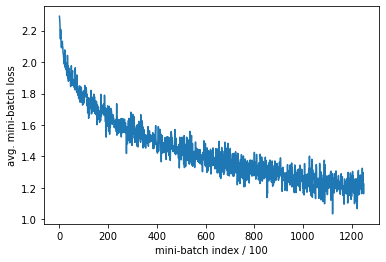

In [23]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [24]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

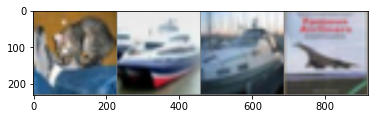

In [26]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


In [28]:
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship truck  ship


In [30]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
#         images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [32]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
#         images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 77 %
Accuracy of  bird : 38 %
Accuracy of   cat : 26 %
Accuracy of  deer : 49 %
Accuracy of   dog : 48 %
Accuracy of  frog : 63 %
Accuracy of horse : 61 %
Accuracy of  ship : 73 %
Accuracy of truck : 68 %


In [21]:
torch.save(net.state_dict(), 'AlexNet.pt')

In [35]:
import torchsummary

In [37]:
torchsummary.summary(net, input_size=(3, 227, 227))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            432
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Sequential: 1-4                        --
|    └─DepthwiseSeparableConv: 2-1       --
|    |    └─Conv2d: 3-1                  144
|    |    └─BatchNorm2d: 3-2             32
|    |    └─Conv2d: 3-3                  512
|    |    └─BatchNorm2d: 3-4             64
|    |    └─ReLU: 3-5                    --
|    └─DepthwiseSeparableConv: 2-2       --
|    |    └─Conv2d: 3-6                  288
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  2,048
|    |    └─BatchNorm2d: 3-9             128
|    |    └─ReLU: 3-10                   --
|    └─DepthwiseSeparableConv: 2-3       --
|    |    └─Conv2d: 3-11                 576
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 4,096
|    |    └─BatchNorm2d: 3-14            128
|    |    └─R

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            432
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Sequential: 1-4                        --
|    └─DepthwiseSeparableConv: 2-1       --
|    |    └─Conv2d: 3-1                  144
|    |    └─BatchNorm2d: 3-2             32
|    |    └─Conv2d: 3-3                  512
|    |    └─BatchNorm2d: 3-4             64
|    |    └─ReLU: 3-5                    --
|    └─DepthwiseSeparableConv: 2-2       --
|    |    └─Conv2d: 3-6                  288
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  2,048
|    |    └─BatchNorm2d: 3-9             128
|    |    └─ReLU: 3-10                   --
|    └─DepthwiseSeparableConv: 2-3       --
|    |    └─Conv2d: 3-11                 576
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 4,096
|    |    └─BatchNorm2d: 3-14            128
|    |    └─R

In [38]:
torch.save(net.state_dict(), 'MobileNet.pt')

In [5]:
import torchsummary

In [6]:
torchsummary.summary(net, input_size=(3, 227, 227))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            432
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Sequential: 1-4                        --
|    └─DepthwiseSeparableConv: 2-1       --
|    |    └─Conv2d: 3-1                  144
|    |    └─BatchNorm2d: 3-2             32
|    |    └─Conv2d: 3-3                  512
|    |    └─BatchNorm2d: 3-4             64
|    |    └─ReLU: 3-5                    --
|    └─DepthwiseSeparableConv: 2-2       --
|    |    └─Conv2d: 3-6                  288
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  2,048
|    |    └─BatchNorm2d: 3-9             128
|    |    └─ReLU: 3-10                   --
|    └─DepthwiseSeparableConv: 2-3       --
|    |    └─Conv2d: 3-11                 576
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 4,096
|    |    └─BatchNorm2d: 3-14            128
|    |    └─R

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            432
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Sequential: 1-4                        --
|    └─DepthwiseSeparableConv: 2-1       --
|    |    └─Conv2d: 3-1                  144
|    |    └─BatchNorm2d: 3-2             32
|    |    └─Conv2d: 3-3                  512
|    |    └─BatchNorm2d: 3-4             64
|    |    └─ReLU: 3-5                    --
|    └─DepthwiseSeparableConv: 2-2       --
|    |    └─Conv2d: 3-6                  288
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  2,048
|    |    └─BatchNorm2d: 3-9             128
|    |    └─ReLU: 3-10                   --
|    └─DepthwiseSeparableConv: 2-3       --
|    |    └─Conv2d: 3-11                 576
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 4,096
|    |    └─BatchNorm2d: 3-14            128
|    |    └─R